<a href="https://colab.research.google.com/github/GitG3H/git-tuts/blob/master/Denoise_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Denoise AutoEncoder**

In [1]:
# import libraries
import numpy as np
from keras.datasets import mnist

In [4]:
#Using Keras MNIST dataset and splitting train and test data for the model
(X_train, _),(X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

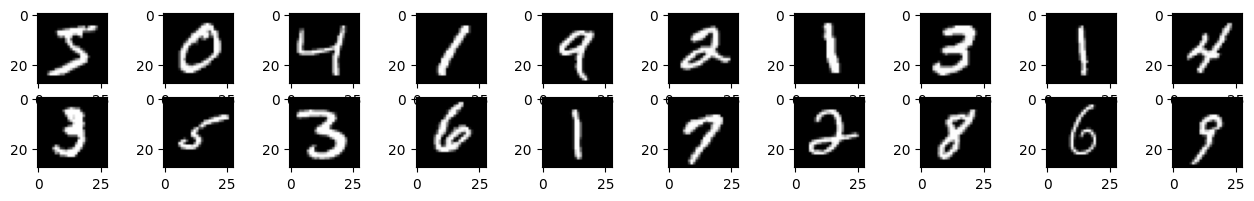

In [5]:
# Use matplotlib for data visualization
import matplotlib.pyplot as plt
#Use subplot to plot multiple images
fig, axes = plt.subplots(2,10, figsize = (16,2))

# For every row and every columnn of a row, plot a single image from training dataset, when the loop ends you will have row times column number of images plotted on a grid.

count = 0
for i in range(2):
  for j in range(10):
    axes[i,j].imshow(X_train[count], cmap ='gray')
    count += 1

##**Normalize**

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

##**Add noise to images**
### The data now we have is clean, we can use it as target data. Add noise to get source data.

In [7]:
#prepare source data

#noise factor decides how much noise should be added and take current dataset , add random noise using normal distribution
noise_factor = 0.1

X_train_noise = X_train + noise_factor*np.random.normal(loc=0,scale=1., size = X_train.shape)
X_test_noise = X_test + noise_factor*np.random.normal(loc=0,scale=1., size = X_test.shape)

#**Visualize noised data**

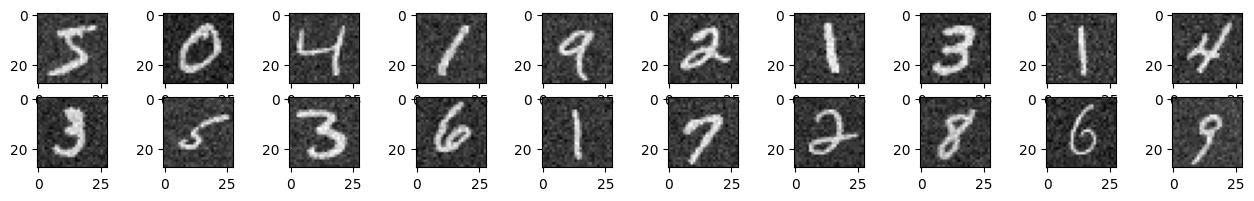

In [8]:
# Use matplotlib for data visualization
import matplotlib.pyplot as plt
#Use subplot to plot multiple images
fig, axes = plt.subplots(2,10, figsize = (16,2))

# For every row and every columnn of a row, plot a single image from training dataset, when the loop ends you will have row times column number of images plotted on a grid.

count = 0
for i in range(2):
  for j in range(10):
    axes[i,j].imshow(X_train_noise[count], cmap ='gray')
    count += 1

##**Reshape dataset**

## We have 2D dataset till now, To feed this in CNN, We have to convert it in 3D tensor, easiest way to do it is to reshape both source and target data.

In [9]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0],28,28,1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0],28,28,1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

##**Create Model**

import all neccessary libraries required to make encoder and decoder

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization

import tensorflow as tf

In [11]:
devices = tf.config.experimental.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(devices[0], enable = True)

In [12]:
# encoder
encoder_input = Input(shape = X_train.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)

In [15]:
#decoder: use of upsampling layers
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
#Use CNN with single filter to deconstruct the target from previous 32 filters, We are taking Sigmoid here because we have normalised data ranging from 0 to 1, so Sigmoid is the best activation function
decoded = Conv2D(1,(3,3), activation = 'sigmoid', padding = 'same')(x)

In [16]:
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)    

In [17]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam')

##**Train the model**

In [18]:
#Using callback called model checkpoint to save best model throughout the training
checkpoint = ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only = False, verbose =1)
history = autoencoder.fit(X_train_noise, X_train, batch_size = 128, epochs = 50, callbacks = checkpoint, validation_split = 0.25, verbose =2)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.14134, saving model to denoising_model.h5
352/352 - 25s - loss: 0.1664 - val_loss: 0.1413 - 25s/epoch - 71ms/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.14134 to 0.07815, saving model to denoising_model.h5
352/352 - 22s - loss: 0.0769 - val_loss: 0.0782 - 22s/epoch - 62ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.07815 to 0.07569, saving model to denoising_model.h5
352/352 - 21s - loss: 0.0737 - val_loss: 0.0757 - 21s/epoch - 60ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.07569 to 0.07213, saving model to denoising_model.h5
352/352 - 20s - loss: 0.0720 - val_loss: 0.0721 - 20s/epoch - 58ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.07213 to 0.07124, saving model to denoising_model.h5
352/352 - 21s - loss: 0.0712 - val_loss: 0.0712 - 21s/epoch - 60ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.07124 to 0.07065, saving model to denoising_model.h5
352/352 - 21s - loss: 0.0705 - val_loss: 0.0706 - 21s/epoch - 59ms/step
Epoch 7/50

Epoch 7: val_loss improved from 0.07065 to 0.07019, saving model to denoising_model.h5
352/352 - 22s - loss: 0.0701 - val_loss: 0.0702 - 22s/epo

In [19]:
# load the best performance model saved during training, using the name you have specified in the model checkpoint and use summary to verify if it is loaded properly.
from keras.models import load_model
autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)    

In [20]:
#Write a function for visulaizing the predicted data.
def visualize_data(data, row, column):
  data = data.reshape(data.shape[0],28,28) #Reshape the data into matrix because the predicted data is in tensor.
  count = 0 #define count to iterate through each sample
  fig, axes = plt.subplots(row, column, figsize = (16,4)) #Recreate an empty grid for images of size of row*column
  for i in range(row):
    for j in range(column):
      axes[i,j].imshow(data[count], cmap = 'gray') #plot the images using imshow() function
      count+=1 #increase the count to generate another image


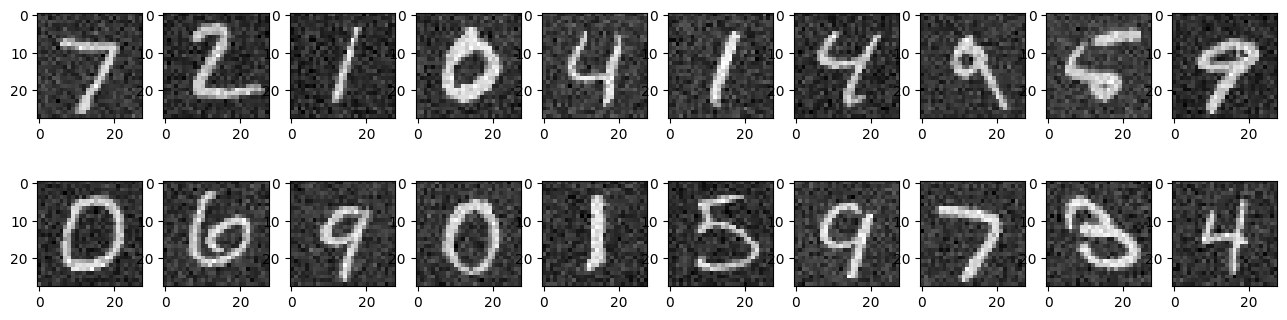

In [21]:
#visulaize the test data, it is noisy right!.
visualize_data(X_test_noise[:20],2,10)

In [22]:
#Lets clean the noise in it by feeding the noisy data into model and get its prediction.
pred = autoencoder.predict(X_test[:20])
pred.shape

1/1 [==============================] - 0s 142ms/step


(20, 28, 28, 1)

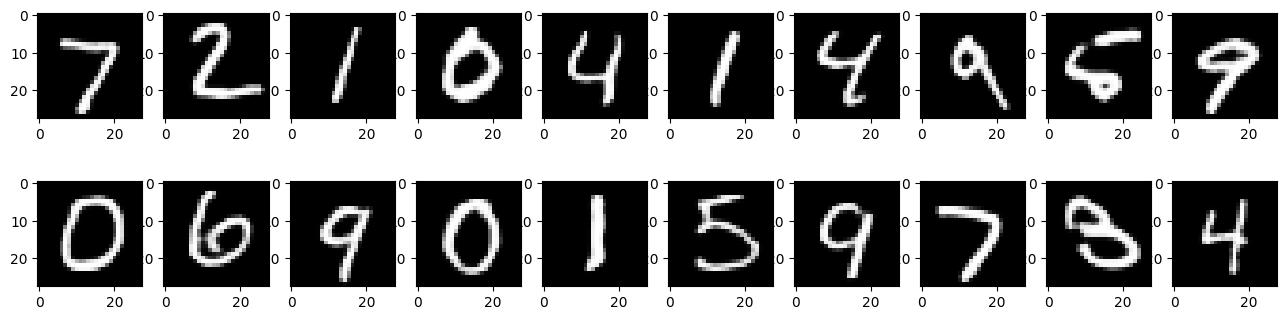

In [23]:
#Visualize the predicted data using same function
#Now it will be better with less noise.
visualize_data(pred,2,10)

#**Things to remember:**

1.   The goal of DAE is to avoid approximating the identity function.
2.   You can use denoising autoencoder to reconstruct corrupted data.
3.   You can use this as a feature selection tool as it filters out the noise.





